### Aplaneamiento

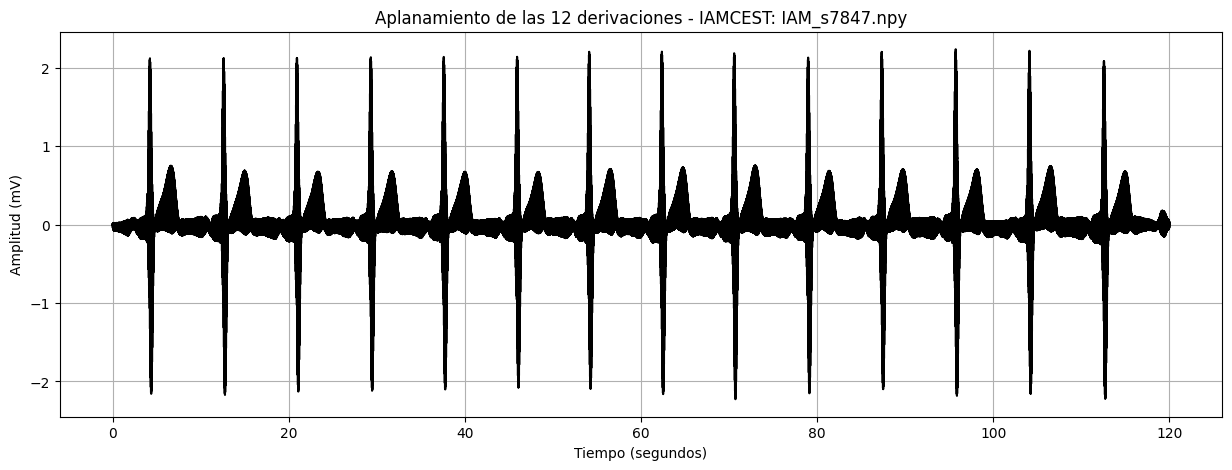

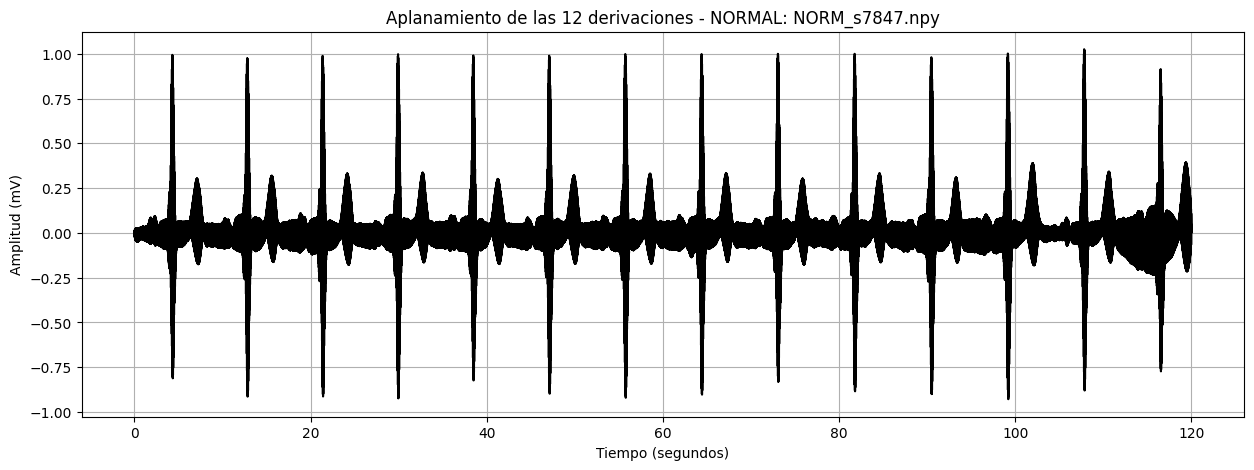

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Nota: Los archivos .npy contienen las señales de ECG preprocesadas.

# Rutas
aplanados_dir = r"C:\Users\Alejandra\OneDrive\Escritorio\Base de datos tesis\ECG_aplanados"

# Función para visualizar una señal aplanada
def visualizar_ecg(categoria, archivo_ejemplo):
    ruta_archivo = os.path.join(aplanados_dir, categoria, archivo_ejemplo)
    
    if os.path.exists(ruta_archivo):
        ecg_aplanado = np.load(ruta_archivo)
        fs = 500
        tiempo = np.arange(0, len(ecg_aplanado)) / fs
        
        plt.figure(figsize=(15, 5))
        plt.plot(tiempo, ecg_aplanado, label='ECG aplanado', color='black')
        
        plt.xlabel('Tiempo (segundos)')
        plt.ylabel('Amplitud (mV)')
        plt.title(f'Aplanamiento de las 12 derivaciones - {categoria}: {archivo_ejemplo}')
        plt.grid(True)
        plt.show()
    else:
        print(f"Archivo no encontrado: {ruta_archivo}")

# Ejemplos de archivos
visualizar_ecg("IAMCEST", "IAM_s7847.npy")
visualizar_ecg("NORMAL", "NORM_s7847.npy")


In [ ]:
from tensorflow.keras.utils import Sequence
import os
import numpy as np
from sklearn.model_selection import train_test_split

class ECGDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size=16, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels  
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.file_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_files = [self.file_paths[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes] 
        X = np.array([np.load(f).astype(np.float32)[:, np.newaxis] for f in batch_files])  
        y = np.array(batch_labels) 
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Definir rutas y etiquetas
aplanados_dir = r"C:\Users\Alejandra\OneDrive\Escritorio\Base de datos tesis\ECG_aplanados"
iam_files = [os.path.join(aplanados_dir, "IAMCEST", f) for f in os.listdir(os.path.join(aplanados_dir, "IAMCEST")) if f.endswith('.npy')]
normal_files = [os.path.join(aplanados_dir, "NORMAL", f) for f in os.listdir(os.path.join(aplanados_dir, "NORMAL")) if f.endswith('.npy')]
all_files = iam_files + normal_files
all_labels = [1] * len(iam_files) + [0] * len(normal_files)  # 1 para IAMCEST, 0 para NORMAL
print(f"All labels: {all_labels.count(1)} IAMCEST, {all_labels.count(0)} NORMAL")

# Dividir en entrenamiento y prueba
train_files, test_files, train_labels, test_labels = train_test_split(
    all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)
print(f"Train files: {len(train_files)}, Train labels: {train_labels.count(1)} IAMCEST, {train_labels.count(0)} NORMAL")
print(f"Test files: {len(test_files)}, Test labels: {test_labels.count(1)} IAMCEST, {test_labels.count(0)} NORMAL")

# Crear generadores
train_gen = ECGDataGenerator(train_files, train_labels, batch_size=16)
test_gen = ECGDataGenerator(test_files, test_labels, batch_size=16)

X, y = test_gen[0]
print(f"Test batch X shape: {X.shape}, y shape: {y.shape}, y values: {y}")

All labels: 8652 IAMCEST, 8850 NORMAL
Train files: 14001, Train labels: 6921 IAMCEST, 7080 NORMAL
Test files: 3501, Test labels: 1731 IAMCEST, 1770 NORMAL
Test batch X shape: (16, 60000, 1), y shape: (16,), y values: [1 0 0 0 0 1 0 0 1 1 1 1 0 0 0 1]


### Modelo CNN-1D

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout, BatchNormalization

# Definición de Modelo
model = Sequential([
    # Bloque 1
    Conv1D(32, kernel_size=3, activation='relu', padding='same', input_shape=(None, 1)),
    BatchNormalization(),
    Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    # Bloque 2
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Bloque 3
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),

    GlobalAveragePooling1D(),


    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Una neurona para clasificación binaria
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_62 (Conv1D)              │ (None, None, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, None, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_63 (Conv1D)              │ (None, None, 32)       │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, None, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_31 (MaxPooling1D) │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_64 (Conv1D)              │ (None, None, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, None, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_65 (Conv1D)              │ (None, None, 64)       │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_65          │ (None, None, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_32 (MaxPooling1D) │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_66 (Conv1D)              │ (None, None, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_66          │ (None, None, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_67 (Conv1D)              │ (None, None, 128)      │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_67          │ (None, None, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_12     │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 114,209 (446.13 KB)

 Trainable params: 113,313 (442.63 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Definir callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # Detiene si no mejora
    ModelCheckpoint('best_model_binario.h5', monitor='val_accuracy', save_best_only=True)  # Guarda el mejor modelo
]

# Entrenar el modelo
history = model.fit(
    train_gen,                
    validation_data=test_gen,  
    epochs=15,               
    batch_size=16,           
    verbose=1,               
    callbacks=callbacks      
)
# Guardar el modelo final
model.save('final_model_CNN.h5') 

Epoch 1/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8849 - loss: 0.2766

876/876 ━━━━━━━━━━━━━━━━━━━━ 5359s 6s/step - accuracy: 0.8849 - loss: 0.2766 - val_accuracy: 0.8766 - val_loss: 0.2979
Epoch 2/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8929 - loss: 0.2630

876/876 ━━━━━━━━━━━━━━━━━━━━ 5360s 6s/step - accuracy: 0.8929 - loss: 0.2630 - val_accuracy: 0.8903 - val_loss: 0.2613
Epoch 3/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8954 - loss: 0.2549

876/876 ━━━━━━━━━━━━━━━━━━━━ 5331s 6s/step - accuracy: 0.8954 - loss: 0.2549 - val_accuracy: 0.8952 - val_loss: 0.2441
Epoch 4/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9016 - loss: 0.2407

876/876 ━━━━━━━━━━━━━━━━━━━━ 5315s 6s/step - accuracy: 0.9016 - loss: 0.2407 - val_accuracy: 0.9017 - val_loss: 0.2397
Epoch 5/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 5316s 6s/step - accuracy: 0.9075 - loss: 0.2287 - val_accuracy: 0.8929 - val_loss: 0.2593
Epoch 6/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9045 - loss: 0.2391

876/876 ━━━━━━━━━━━━━━━━━━━━ 5331s 6s/step - accuracy: 0.9045 - loss: 0.2391 - val_accuracy: 0.9020 - val_loss: 0.2469
Epoch 7/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 5317s 6s/step - accuracy: 0.9053 - loss: 0.2324 - val_accuracy: 0.9015 - val_loss: 0.2512
Epoch 8/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9107 - loss: 0.2176

876/876 ━━━━━━━━━━━━━━━━━━━━ 5313s 6s/step - accuracy: 0.9107 - loss: 0.2176 - val_accuracy: 0.9095 - val_loss: 0.2255
Epoch 9/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 5328s 6s/step - accuracy: 0.9170 - loss: 0.2105 - val_accuracy: 0.8897 - val_loss: 0.2870
Epoch 10/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 5425s 6s/step - accuracy: 0.9185 - loss: 0.2068 - val_accuracy: 0.8946 - val_loss: 0.2607
Epoch 11/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9159 - loss: 0.2050

876/876 ━━━━━━━━━━━━━━━━━━━━ 5456s 6s/step - accuracy: 0.9159 - loss: 0.2050 - val_accuracy: 0.9140 - val_loss: 0.2094
Epoch 12/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 5519s 6s/step - accuracy: 0.9211 - loss: 0.2013 - val_accuracy: 0.9097 - val_loss: 0.2321
Epoch 13/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 5521s 6s/step - accuracy: 0.9169 - loss: 0.1980 - val_accuracy: 0.8855 - val_loss: 0.2930
Epoch 14/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 5338s 6s/step - accuracy: 0.9194 - loss: 0.1989 - val_accuracy: 0.9140 - val_loss: 0.2123
Epoch 15/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 5182s 6s/step - accuracy: 0.9227 - loss: 0.1934 - val_accuracy: 0.9117 - val_loss: 0.2210


Exactitud: 0.91


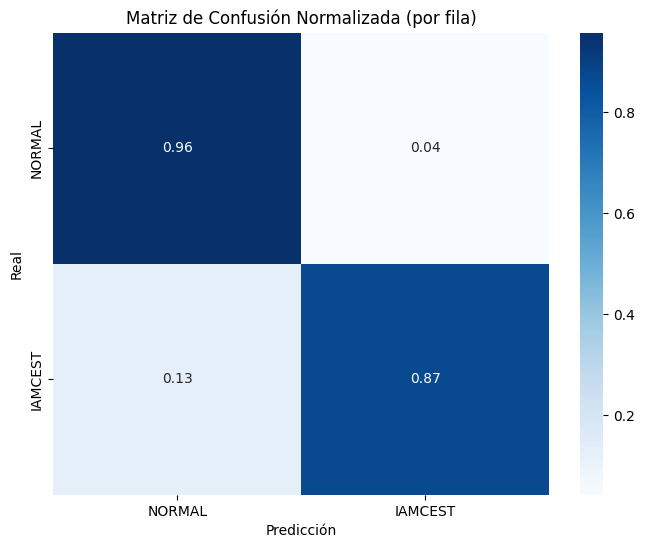

              precision    recall  f1-score   support

      NORMAL       0.88      0.96      0.92      1770
     IAMCEST       0.95      0.87      0.91      1731

    accuracy                           0.91      3501
   macro avg       0.92      0.91      0.91      3501
weighted avg       0.92      0.91      0.91      3501



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Función para obtener predicciones y etiquetas reales
def get_predictions_and_labels(generator, model):
    y_true = []
    y_pred = []
    for i in range(len(generator)):
        X, y = generator[i]
        y_prob_batch = model.predict(X, verbose=0)  
        y_true.extend(y)  
        y_pred.extend((y_prob_batch > 0.5).astype(int).flatten()) 
    return np.array(y_true), np.array(y_pred)

# Obtener predicciones y etiquetas del conjunto de prueba
y_true, y_pred = get_predictions_and_labels(test_gen, model)

accuracy = accuracy_score(y_true, y_pred)
print(f"Exactitud: {accuracy:.2f}")

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 


plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['NORMAL', 'IAMCEST'], yticklabels=['NORMAL', 'IAMCEST'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Normalizada (por fila)')
plt.show()

# Imprimir reporte de clasificación
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'IAMCEST']))

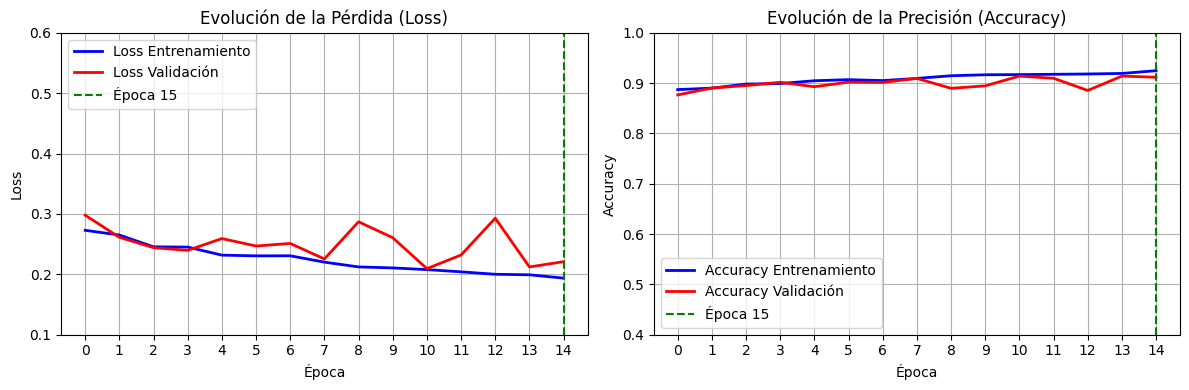

Loss final de entrenamiento: 0.1937
Loss final de validación: 0.2210
Accuracy final de entrenamiento: 0.9247
Accuracy final de validación: 0.9117


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))  

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss Entrenamiento', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Loss Validación', color='red', linewidth=2)
plt.title('Evolución de la Pérdida (Loss)', fontsize=12)
plt.xlabel('Época', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(fontsize=10)
plt.grid(True)
#
max_epochs = len(history.history['loss'])
plt.xticks(range(0, max_epochs))  
plt.ylim(0.1, 0.6)  

plt.axvline(x=14, color='green', linestyle='--', label='Época 15')  # x=14 para época 15
plt.legend(fontsize=10)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy Entrenamiento', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Accuracy Validación', color='red', linewidth=2)
plt.title('Evolución de la Precisión (Accuracy)', fontsize=12)
plt.xlabel('Época', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.legend(fontsize=10)
plt.grid(True)

# Marcas cada época
plt.xticks(range(0, max_epochs))  
plt.ylim(0.4, 1.0)  

plt.axvline(x=14, color='green', linestyle='--', label='Época 15')  # x=14 para época 15
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Imprimir valores finales para referencia
print(f"Loss final de entrenamiento: {history.history['loss'][-1]:.4f}")
print(f"Loss final de validación: {history.history['val_loss'][-1]:.4f}")
print(f"Accuracy final de entrenamiento: {history.history['accuracy'][-1]:.4f}")
print(f"Accuracy final de validación: {history.history['val_accuracy'][-1]:.4f}")

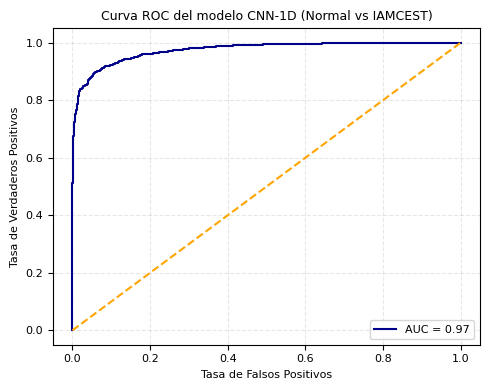

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def get_predictions_and_probabilities(generator, model):
    y_true = []
    y_prob = []
    for i in range(len(generator)):
        X, y = generator[i]
        y_prob_batch = model.predict(X, verbose=0)

        y_true_batch = np.argmax(y, axis=1) if y.ndim > 1 else y 
        y_true.extend(y_true_batch)
        y_prob.extend(y_prob_batch.flatten()) 
    return np.array(y_true), np.array(y_prob)

# Obtener datos del conjunto de prueba
y_true, y_prob = get_predictions_and_probabilities(test_gen, model)


fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkblue', lw=1.5, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='orange', lw=1.5, linestyle='--')

plt.title('Curva ROC del modelo CNN-1D (Normal vs IAMCEST)', fontsize=9)
plt.xlabel('Tasa de Falsos Positivos', fontsize=8)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=8)
plt.legend(loc="lower right", fontsize=8)
plt.grid(alpha=0.3, linestyle='--')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()